# Using Network Graphs To Visualize Potential Fraud on the Blockchain
### Author: On the Mark Data (Learn more at onthemarkdata.com!)
### Accompanying Blog: Coming Soon

Whether you are an NFT advocate or skeptic, one thing can't be denied-- the blockchain provides one of the largest public real-world datasets available to any data professional. In this notebook you will learn the following:
1. How to pull your own NFT data using the open source package `NFT Analyst Starter Pack` from a16z.
2. Understanding how to interpret Ethereum blockchain data.
3. Learn about the fraudulent practice of "wash trading" NFTs.
4. Constructing network graphs to visualize potential wash trading on the NFT project Bored Ape Yacht Club.

This notebook will focus on applying the data concepts, but the blog will provide further context!

Important Notes:
- This is for educational purposes only and is not financial advice.
- I do not have any financial ties to the analyzed NFTs and the moment of releasing this notebook-- here is my wallet address on etherscan for reference (https://etherscan.io/address/0x668f04305bd799935352383884444b5d6b378840).
- This is only highlighting *potential* fraud to investigate further, but does not prove fraud has taken place.
- If you own crypto, NEVER share your "secret recovery phrase" or "private keys" with anyone.

# Background Information
### What's a Network Graph?
Networks are a way in which to organize relationship data in the form of "nodes" and "edges" where the nodes represent an entity (e.g. email address, social media user, etc.) and the edges represent the connection between nodes. In addition, one can store metadata for nodes and edges such as weights and labels to represent different aspects of relationships.

### What is Blockchain Data?
I have a more in-depth explanation of Ethereum data in this Medium blog: https://onthemarkdata.medium.com/making-sense-of-ethereum-data-for-analytics-17655c4859d0

Here is an excerpt that best describes this: "At a very high level, blockchains are ledgers of transactions utilizing cryptography that can only add information and thus can’t be changed (i.e., immutable). What separates blockchains from ledgers you find at banks is a concept called “decentralization” — where every computer connected to a respective blockchain must “agree” on the same state of the blockchain and subsequent data added to it."

Key to this is that all the data (e.g. logs, metadata, etc.) must be public and accessible, which data professionals can leverage!

### What's an NFT?
NFTs, or “non-fungible tokens,” are unique one-of-one tokens representing ownership of an asset on the blockchain, such as digital art, music, or even [legal documents](https://www.bloomberg.com/news/articles/2022-07-13/you-ve-been-served-via-nft-court-gives-ok-to-sue-on-blockchain) [hyperlink to Bloomberg article]. For more detail, I highly encourage checking out this great [intro video on the topic by Finematics](https://youtu.be/Xdkkux6OxfM).

## Import Packages

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from string import ascii_uppercase
from operator import itemgetter

## Prepare Notebook Environment

In [2]:
# useful for ensuring long crypto addresses can be fully seen
pd.set_option('display.max_colwidth', None)

# useful for making visible plots
plt.rcParams['figure.figsize'] = [10, 10]

## Import Data
We will use the `NFT Analyst Starter Pack` from a16z. Please follow the instructions on the package's GitHub page for setting up the script to pull your desired NFT data. This notebook analyzes the NFT project Bored Ape Yacht Club, so please use the contract address `0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d`. I have also included the data in this notebook's repository if you want to skip this step or replicate my exact results. For a more in-depth explanation of data sources, please check out the accompanying blog.

### BAYC Metadata
- Information regarding a specific NFT where asset_id is the unique identifier within this NFT token.
    - Note: On the blockchain, the unique identifier is the composite key of the `asset_id` (i.e. "token id") and the contract address (i.e. the string representing the contract hash of the respective NFT).
- `NaN`s are expected and inform that the respective NFT does not have the attribute in the represented column.
- Rarity scores are the proportion of `asset_id`s with a respective attribute.
    - Example:
        - ~33% of tokens within BAYC have a "Sea Captain's Hat."
        - ~4% of tokens have no hat as represented by `NaN`.
    - Considerations:
        - The importance of rarity scores is very dependent on the NFT project and overall sentiment of rarity within th NFT market as a whole.
        - Values such as perceived beauty, being "the first," and cultural significance (both on a micro and macro level) can supersede rarity.

Note: We won't be using this data, but thought it was important to share to help others learn more about NFTs and BAYC.

In [3]:
metadata = "metadata_0xBC4CA0EdA7647A8aB7C2061c2E118A18a936f13D_04302022.csv"
bayc_metadata = pd.read_csv(f"../bayc_nft_data/{metadata}")
print(bayc_metadata.info())
bayc_metadata.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   asset_id                      10000 non-null  int64  
 1   attribute_count               10000 non-null  int64  
 2   attribute_count_rarity_score  10000 non-null  float64
 3   Hat_attribute                 7744 non-null   object 
 4   Hat_rarity_score              10000 non-null  float64
 5   Background_attribute          10000 non-null  object 
 6   Background_rarity_score       10000 non-null  float64
 7   Clothes_attribute             8114 non-null   object 
 8   Clothes_rarity_score          10000 non-null  float64
 9   Mouth_attribute               10000 non-null  object 
 10  Mouth_rarity_score            10000 non-null  float64
 11  Fur_attribute                 10000 non-null  object 
 12  Fur_rarity_score              10000 non-null  float64
 13  Ey

,asset_id,attribute_count,attribute_count_rarity_score,Hat_attribute,Hat_rarity_score,Background_attribute,Background_rarity_score,Clothes_attribute,Clothes_rarity_score,Mouth_attribute,Mouth_rarity_score,Fur_attribute,Fur_rarity_score,Eyes_attribute,Eyes_rarity_score,Earring_attribute,Earring_rarity_score,overall_rarity_score
0,0,6,1.878640,NaN,4.432624,Orange,7.855460,Striped Tee,24.271845,Discomfort,48.076923,Robot,37.735849,X Eyes,41.152263,Silver Hoop,11.337868,176.741472
1,1,5,3.937008,NaN,4.432624,Orange,7.855460,Vietnam Jacket,44.642857,Grin,14.025245,Robot,37.735849,Blue Beams,204.081633,NaN,1.423893,318.134569
2,2,5,3.937008,Sea Captain's Hat,32.894737,Aquamarine,7.898894,NaN,5.302227,Bored Cigarette,14.084507,Robot,37.735849,3d,20.533881,NaN,1.423893,123.810996
3,3,5,3.937008,NaN,4.432624,Purple,7.745933,Bone Necklace,49.261084,Tongue Out,49.504950,Cheetah,24.630542,Bored,5.834306,NaN,1.423893,146.770340
4,4,6,1.878640,Party Hat 2,93.457944,Blue,8.051530,Navy Striped Tee,29.940120,Phoneme L,41.493776,Golden Brown,12.853470,Closed,14.084507,NaN,1.423893,203.183880


### BAYC Sales
- One of the most powerful attributes of the blockchain is the ability to validate transaction for yourself via the `transaction_hash`
    - Go to etherscan.com and search the `transaction_hash` represented by `bayc_sales['transaction_hash'][0]` where you can find all information related to the transaction and the NFT.
    - Validate that the information represented in the dataframe matches etherscan.
        - Note: The `seller` address on etherscan is represented by an "ENS Domain" (i.e. the ".eth" names), but hovering over that value will show the expected address.
- `transaction_hash` will serve as the unique identifier and `seller` and `buyer` will be utilized to generate our network graph.

In [4]:
sales = "sales_0xBC4CA0EdA7647A8aB7C2061c2E118A18a936f13D_04302022.csv"
bayc_sales = pd.read_csv(f"../bayc_nft_data/{sales}")
print(bayc_sales.info())
bayc_sales.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26310 entries, 0 to 26309
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   transaction_hash  26310 non-null  object 
 1   block_number      26310 non-null  int64  
 2   date              26310 non-null  object 
 3   asset_id          26310 non-null  int64  
 4   seller            26310 non-null  object 
 5   buyer             26310 non-null  object 
 6   maker             26310 non-null  object 
 7   taker             26310 non-null  object 
 8   sale_price_eth    26310 non-null  float64
 9   sale_price_usd    26310 non-null  float64
dtypes: float64(2), int64(2), object(6)
memory usage: 2.0+ MB
None


,transaction_hash,block_number,date,asset_id,seller,buyer,maker,taker,sale_price_eth,sale_price_usd
0,0xb235f0321b0b50198399ec7f2bb759ef625f85673b4d90d68f711229750181e4,14675897,2022-04-28,7438,0x2fdcca65899346af3a93a8daa6128bdbcb1ce3b3,0xcedf17dfafa947cd0e205fe2a3a183cf2fb3a0bc,0x2fdcca65899346af3a93a8daa6128bdbcb1ce3b3,0xcedf17dfafa947cd0e205fe2a3a183cf2fb3a0bc,153.200,442685.528567
1,0x1cf83a120540049239c62de9aa6cbc42bae7494cdf029419f2aa0b2df708e13b,14675814,2022-04-28,1397,0xcedf17dfafa947cd0e205fe2a3a183cf2fb3a0bc,0x93d1f7636f56dd4498c778e212cbe3e2e15bcba9,0xcedf17dfafa947cd0e205fe2a3a183cf2fb3a0bc,0x93d1f7636f56dd4498c778e212cbe3e2e15bcba9,139.750,403820.513167
2,0xf9854d2f02c074f1a2043bc93c5e4e6e4e922e6908a8d1a61ea1ea19e39a729c,14675812,2022-04-28,5226,0x40c839b831c90173dc7fbce49a25274a4688ddd9,0xd30cad3f023888d5a81580fbb80f93102d69e9ef,0x40c839b831c90173dc7fbce49a25274a4688ddd9,0x00000000a50bb64b4bbeceb18715748dface08af,150.000,433438.833453
3,0x38c03f0e17422b62f450262e2931a86efa201d3c22e908457a79a090cd935ab8,14675760,2022-04-28,6498,0x83e7fc69d7c99943afd9122ad0f8bb575e00597c,0x8dd47e819c53138aa18f8651d797e7969f34d1f1,0x83e7fc69d7c99943afd9122ad0f8bb575e00597c,0x8dd47e819c53138aa18f8651d797e7969f34d1f1,145.678,420950.015866
4,0x85ec6a319062f3537420ba60342ff273bbad907bfd9d7559628064455d4b7c26,14675332,2022-04-28,8028,0xe87cc2ea916a7d471976b675d5f72302908e4590,0x98bea99727b297f5eca448d1640075f349c08547,0xe87cc2ea916a7d471976b675d5f72302908e4590,0x98bea99727b297f5eca448d1640075f349c08547,128.000,369867.804547


### BAYC Transfers
- Another way to move an NFT asset to another wallet is via transfers.
- Keep in mind that transfers still require money to move (i.e. "gas fees"), but no money is sent to the receiving wallet.
- For legal transactions, transfers allow the owner to better organize their crypto wallets-- especially moving to wallets with extra security (e.g. cold wallets, and multi-sig authorization)
- For illegal transactions, hacked wallets typically result in the entire wallet contents being transferred to the hacker's respective wallet.

In [5]:
transfers = "transfers_0xBC4CA0EdA7647A8aB7C2061c2E118A18a936f13D_04302022.csv"
bayc_transfers = pd.read_csv(f"../bayc_nft_data/{transfers}")
print(bayc_transfers.info())
bayc_transfers.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67859 entries, 0 to 67858
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   transaction_hash  67859 non-null  object
 1   block_number      67859 non-null  int64 
 2   date              67859 non-null  object
 3   asset_id          67859 non-null  int64 
 4   from_address      67859 non-null  object
 5   to_address        67859 non-null  object
dtypes: int64(2), object(4)
memory usage: 3.1+ MB
None


,transaction_hash,block_number,date,asset_id,from_address,to_address
0,0x76b6196f390319fc3c0153bccb82c6e3667298a70d55458b3a756aa990679b3a,14675899,2022-04-28,5037,0xff389e55ee4dd64d82b2b6fefef3f7aa63b218fd,0x3b968d2d299b895a5fcf3bba7a64ad0f566e6f88
1,0x76b6196f390319fc3c0153bccb82c6e3667298a70d55458b3a756aa990679b3a,14675899,2022-04-28,5037,0x5f6ac80cdb9e87f3cfa6a90e5140b9a16a361d5c,0xdbfd76af2157dc15ee4e57f3f942bb45ba84af24
2,0x76b6196f390319fc3c0153bccb82c6e3667298a70d55458b3a756aa990679b3a,14675899,2022-04-28,5037,0x3b968d2d299b895a5fcf3bba7a64ad0f566e6f88,0x70b97a0da65c15dfb0ffa02aee6fa36e507c2762
3,0x76b6196f390319fc3c0153bccb82c6e3667298a70d55458b3a756aa990679b3a,14675899,2022-04-28,5037,0x70b97a0da65c15dfb0ffa02aee6fa36e507c2762,0x5f6ac80cdb9e87f3cfa6a90e5140b9a16a361d5c
4,0xb235f0321b0b50198399ec7f2bb759ef625f85673b4d90d68f711229750181e4,14675897,2022-04-28,7438,0x2fdcca65899346af3a93a8daa6128bdbcb1ce3b3,0xcedf17dfafa947cd0e205fe2a3a183cf2fb3a0bc


## Prepare Data for Network Graph
Our main focus for preparing the data are the following:
- Making sure the sales and transfer data have the same column names and data types so that we can union them.
- Adding additional values for transaction information (e.g. `transaction_type`).
- Removing duplicate transactions if any.

Why spend effort on this step?
- The `from_address` and `to_address` values will be the nodes within the graph, and highlight interactions between wallets.
- The remaining columns will become metadata for the graph network, especially for edges.
    - Most importantly, this metadata will help us create labels which will provide the "data story."

### Sales Data

In [6]:
prepared_bayc_sales = bayc_sales \
    .copy() \
    .loc[:,[
        'transaction_hash',
        'block_number',
        'date',
        'asset_id',
        'seller',
        'buyer',
        'sale_price_eth',
        'sale_price_usd',
        ]
    ] \
    .rename(columns={'seller':'from_address', 'buyer':'to_address'}) \
    .assign(transaction_type='sell') \
    .astype({'block_number':'str', 'asset_id':'str'})

prepared_bayc_sales.head(3)


,transaction_hash,block_number,date,asset_id,from_address,to_address,sale_price_eth,sale_price_usd,transaction_type
0,0xb235f0321b0b50198399ec7f2bb759ef625f85673b4d90d68f711229750181e4,14675897,2022-04-28,7438,0x2fdcca65899346af3a93a8daa6128bdbcb1ce3b3,0xcedf17dfafa947cd0e205fe2a3a183cf2fb3a0bc,153.20,442685.528567,sell
1,0x1cf83a120540049239c62de9aa6cbc42bae7494cdf029419f2aa0b2df708e13b,14675814,2022-04-28,1397,0xcedf17dfafa947cd0e205fe2a3a183cf2fb3a0bc,0x93d1f7636f56dd4498c778e212cbe3e2e15bcba9,139.75,403820.513167,sell
2,0xf9854d2f02c074f1a2043bc93c5e4e6e4e922e6908a8d1a61ea1ea19e39a729c,14675812,2022-04-28,5226,0x40c839b831c90173dc7fbce49a25274a4688ddd9,0xd30cad3f023888d5a81580fbb80f93102d69e9ef,150.00,433438.833453,sell


### Transfers Data

In [7]:
prepared_bayc_transfers = bayc_transfers \
    .copy() \
    .assign(
        sale_price_eth=0.00,
        sale_price_usd=0.00,
        transaction_type='transfer'
    ) \
    .astype({'block_number':'str', 'asset_id':'str'})

prepared_bayc_transfers.head(3)

,transaction_hash,block_number,date,asset_id,from_address,to_address,sale_price_eth,sale_price_usd,transaction_type
0,0x76b6196f390319fc3c0153bccb82c6e3667298a70d55458b3a756aa990679b3a,14675899,2022-04-28,5037,0xff389e55ee4dd64d82b2b6fefef3f7aa63b218fd,0x3b968d2d299b895a5fcf3bba7a64ad0f566e6f88,0.0,0.0,transfer
1,0x76b6196f390319fc3c0153bccb82c6e3667298a70d55458b3a756aa990679b3a,14675899,2022-04-28,5037,0x5f6ac80cdb9e87f3cfa6a90e5140b9a16a361d5c,0xdbfd76af2157dc15ee4e57f3f942bb45ba84af24,0.0,0.0,transfer
2,0x76b6196f390319fc3c0153bccb82c6e3667298a70d55458b3a756aa990679b3a,14675899,2022-04-28,5037,0x3b968d2d299b895a5fcf3bba7a64ad0f566e6f88,0x70b97a0da65c15dfb0ffa02aee6fa36e507c2762,0.0,0.0,transfer


#### Handling duplicate hashes for sales and transfers:
- The ethereum blockchain represents sales as both the exchange of ethereum as a "sale" and the exchange of the NFT as a "transfer" resulting in duplicates.
- This results in duplicate `transaction_hash`s for sale transactions where the transfer is also included.
- We need to remove these duplicate `transaction_hash`s for only the transfers.

Results:
- unique_sales_hash_list: 26113
- unique_transfer_hash_list: 54577
- unique_hash_set: 54577

The fact that the length `unique_hash_set` is not greater than `unique_transfer_hash_list` implies that unique sales `transaction_hash`s are within `unique_transfer_hash_list` as well.

In [8]:
unique_sales_hash_list = prepared_bayc_sales['transaction_hash'] \
    .unique() \
    .tolist()
print(len(unique_sales_hash_list))

unique_transfer_hash_list = prepared_bayc_transfers['transaction_hash'] \
    .unique() \
    .tolist()
print(len(unique_transfer_hash_list))

unique_hash_set = set(unique_sales_hash_list + unique_transfer_hash_list)
print(len(unique_hash_set))

26113
54577
54577


In [9]:
# repeating for readability across cells
unique_sales_hash_list = prepared_bayc_sales['transaction_hash'] \
    .unique() \
    .tolist()

# you can use `isin()` with a `~` for "not in" but I find `query()` to be more
# readable
filtered_prepared_bayc_transfers = prepared_bayc_transfers \
    .query('transaction_hash not in @unique_sales_hash_list')

print(len(filtered_prepared_bayc_transfers['transaction_hash']))

41585


### Combine Sales and Transfers Data
Note: I'm adding the NFT project's respective contract address as `asset_contract` as it will be useful for metadata later. All NFT projects on Ethereum will have a contract address and token ID (i.e. `asset_id`), which helps us identify specific NFTs on the blockchain. Most popular NFTs will have their own contract address, but some projects may have an "OpenSea Shared Storefront Contract" which is essentially a cheaper way to create an NFT project, but results in the contract address being shared among every NFT within the "OpenSea Shared Storefront" (making analytics very difficult).

In [10]:
prepared_bayc_sales_transfers = pd.concat(
    [prepared_bayc_sales, filtered_prepared_bayc_transfers]
    ) \
    .reset_index(drop=True) \
    .assign(asset_contract='0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d')

prepared_bayc_sales_transfers.describe(include =['object', 'float', 'int'])

,transaction_hash,block_number,date,asset_id,from_address,to_address,sale_price_eth,sale_price_usd,transaction_type,asset_contract
count,67895,67895,67895,67895,67895,67895,67895.000000,6.789500e+04,67895,67895
unique,54577,49989,372,10000,15320,19613,NaN,NaN,2,1
top,0x2d654336d0ce4ab3601951bf9e1d7b8474537b6273338d5f326af4d44bb25a70,12346915,2021-05-01,5520,0x0000000000000000000000000000000000000000,0xc310e760778ecbca4c65b6c559874757a4c4ece0,NaN,NaN,transfer,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d
freq,51,85,11374,48,10000,1383,NaN,NaN,41585,67895
mean,NaN,NaN,NaN,NaN,NaN,NaN,8.589896,2.732988e+04,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,26.955004,8.581617e+04,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000e+00,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000e+00,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000e+00,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,1.550000,4.178787e+03,NaN,NaN


## Create Network Graph Data
Now it's time for the most fun part: creating the network graph! There are multiple way to construct a graph, but the easiest in my opinion is to use the function `from_pandas_edgelist()`; Hence why we spent time creating an informative pandas dataframe of the blockchain transactions.
- Documentation: https://networkx.org/documentation/stable/reference/generated/networkx.convert_matrix.from_pandas_edgelist.html
- Further Reference: https://stackoverflow.com/questions/53834084/convert-pandas-dataframe-to-directed-networkx-multigraph

One thing to note is that there are different types of graphs such as `simple graphs`, `di-graphs`, `multi-graphs`, and even `di-multi-graphs`. Choosing the correct graph type is dependent on how you are framing your data problem and what "data story" you ant to tell with your network. For this analysis we are going to use a "directed graph" (i.e. `di-graph`), as it maintains the direction of transactions. Though a `di-multi-graph` would be more accurate in representing multiple transactions in the same direction between two nodes, it makes it considerably harder to create edge labels.


In [11]:
# directed graph
DG = nx.from_pandas_edgelist(
    df=prepared_bayc_sales_transfers,
    source='from_address',
    target='to_address',
    edge_attr=True,
    create_using=nx.DiGraph()
)

# confirm it's correct graph
print(f'Is graph directed: {DG.is_directed()}')
print(f'Is multigraph: {DG.is_multigraph()}')

# view the first two nodes with edge data
list(DG.edges(data=True))[0:2]

Is graph directed: True
Is multigraph: False


[('0x2fdcca65899346af3a93a8daa6128bdbcb1ce3b3',
  '0xcedf17dfafa947cd0e205fe2a3a183cf2fb3a0bc',
  {'transaction_hash': '0xb235f0321b0b50198399ec7f2bb759ef625f85673b4d90d68f711229750181e4',
   'block_number': '14675897',
   'date': '2022-04-28',
   'asset_id': '7438',
   'sale_price_eth': 153.2,
   'sale_price_usd': 442685.5285671361,
   'transaction_type': 'sell',
   'asset_contract': '0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d'}),
 ('0x2fdcca65899346af3a93a8daa6128bdbcb1ce3b3',
  '0xd8fdd6031fa27194f93e1a877f8bf5bfc9b47e1e',
  {'transaction_hash': '0x7b4797061eb16d73a28a869e51745e471e2849a55c80459b2aff7f0205925d74',
   'block_number': '14654313',
   'date': '2022-04-25',
   'asset_id': '5954',
   'sale_price_eth': 0.0,
   'sale_price_usd': 0.0,
   'transaction_type': 'transfer',
   'asset_contract': '0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d'})]

Amazing, we created a network graph dataset representing all of the recorded transactions for the BAYC NFT! Now we can use `nx.draw()` to visualize our amazing network graph.

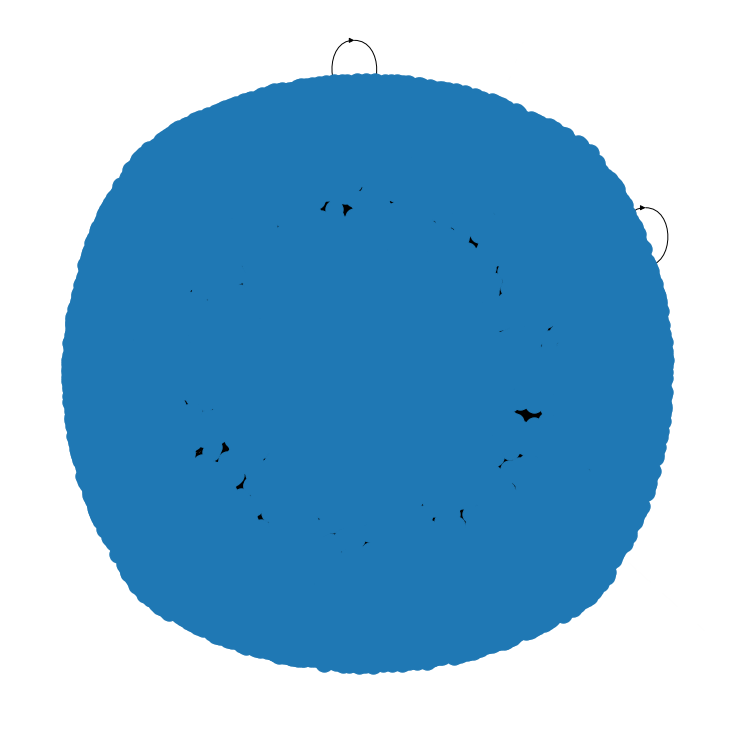

In [12]:
# takes about 20min
nx.draw(DG)

## Creating a Data Story with Network Graphs
As you can see above, just plotting everything can result in a blob of nodes and edges... which is essentially useless. Instead, we need to use some filtering and feature engineering to create a graph that tells a data story.

Since we are interested in visualizing potential fraud on the blockchain, we can focus on all the transactions for a particular NFT (i.e. `asset_id`) and build network graph around it. The following blog highlights BAYC token `8099` as being subjected to the fraudulent practice of "wash trading" where an individual will trade an asset with themselves to artificially inflate the asset price before selling to someone else: https://bitscrunch.com/blogs/nft-wash-trading.

There are unfortunately A LOT of bad actors within web3-- thus, rather relying on information from others, the blockchain empowers us to check for ourselves what transactions happened as everything is public. Not saying it's the case for this blog, but what if hypothetically someone on Twitter called out a specific NFT for wash trading in an effort to devalue an asset so it's cheaper to buy? We should check the data ourselves to be more informed!

### Filter to BAYC NFT Asset `8099`

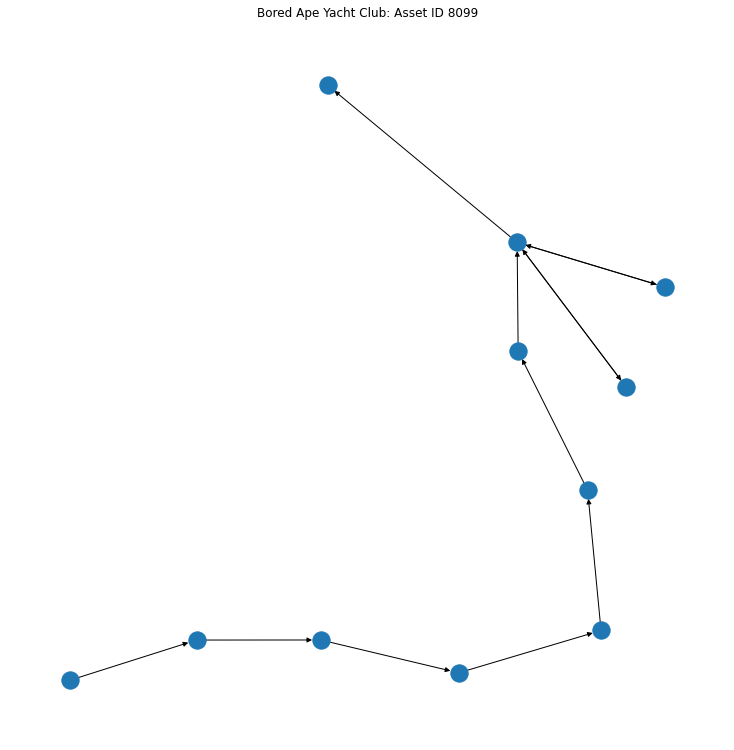

In [13]:
filtered_nft_data = prepared_bayc_sales_transfers \
    .loc[prepared_bayc_sales_transfers['asset_id']=='8099'] \
    .copy()

DG_1 = nx.from_pandas_edgelist(
    df=filtered_nft_data,
    source='from_address',
    target='to_address',
    edge_attr=True,
    create_using=nx.DiGraph()
)

nx.draw(DG_1)
plt.title('Bored Ape Yacht Club: Asset ID 8099')
plt.show()

Now that we have a graph to start off with, we now need to add more detail for our audience to understand what they are looking at within this graph. Emphasis on telling a story of the transactions of a particular NFT.

Useful documentation to reference: https://networkx.org/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw_networkx.html#networkx.drawing.nx_pylab.draw_networkx

### Adding Node Labels

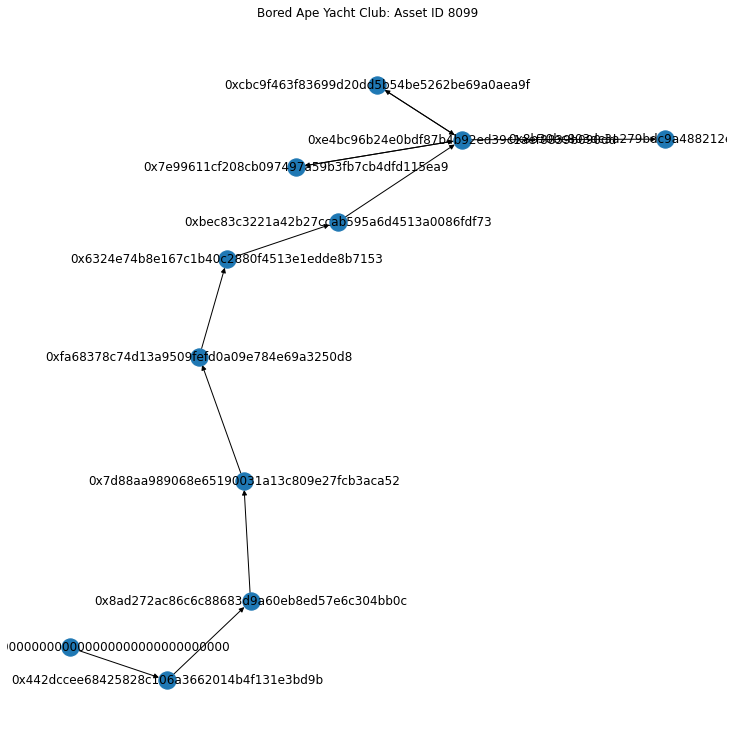

In [14]:
DG_2_a = nx.from_pandas_edgelist(
    df=filtered_nft_data,
    source='from_address',
    target='to_address',
    edge_attr=True,
    create_using=nx.DiGraph()
)

pos = nx.spring_layout(DG_2_a)
nx.draw(DG_2_a, pos=pos)
nx.draw_networkx_labels(G=DG_2_a, pos=pos)
plt.title('Bored Ape Yacht Club: Asset ID 8099')
plt.show()

Though the labels are the exact wallet addresses, it makes the graph overwhelming and unreadable in certain parts. Instead, let's create new labels for each address. To help with conveying the temporal element of transactions as well, let's also have the labels be sequential letters in the order of first appearance of a wallet address for these specific NFT transactions.

In [15]:
label_data = filtered_nft_data.copy()

unique_ordered_from_addresses = label_data \
    .loc[:,['from_address', 'date']] \
    .rename(columns={'from_address':'address'})

unique_ordered_to_addresses = label_data \
    .loc[:,['to_address', 'date']] \
    .rename(columns={'to_address':'address'})

unique_ordered_all_addresses = pd.concat(
    [unique_ordered_from_addresses, unique_ordered_to_addresses]
    ) \
    .groupby('address') \
    .agg('min') \
    .sort_values('date', ascending=True) \
    .reset_index()

unique_ordered_all_addresses

,address,date
0,0x0000000000000000000000000000000000000000,2021-05-01
1,0x442dccee68425828c106a3662014b4f131e3bd9b,2021-05-01
2,0x8ad272ac86c6c88683d9a60eb8ed57e6c304bb0c,2021-05-02
3,0x7d88aa989068e65190031a13c809e27fcb3aca52,2021-06-21
4,0xfa68378c74d13a9509fefd0a09e784e69a3250d8,2021-07-22
5,0x6324e74b8e167c1b40c2880f4513e1edde8b7153,2021-07-25
6,0xbec83c3221a42b27ccab595a6d4513a0086fdf73,2021-07-27
7,0xe4bc96b24e0bdf87b4b92ed39c1aef8839b090dd,2021-08-05
8,0x7e99611cf208cb097497a59b3fb7cb4dfd115ea9,2021-08-07
9,0xcbc9f463f83699d20dd5b54be5262be69a0aea9f,2021-08-29


In [16]:
# https://stackoverflow.com/questions/50860366/pandas-set-row-values-to-letter-of-the-alphabet-corresponding-to-index-number
# get upper case letter in order of index
node_label_series = pd.Series(
    itemgetter(*unique_ordered_all_addresses.index)(ascii_uppercase),
    name='node_label'
    )

address_labels_df = pd.concat(
    [unique_ordered_all_addresses, node_label_series], axis=1
    ) \
    .loc[:,['address', 'node_label']]

address_labels_df

,address,node_label
0,0x0000000000000000000000000000000000000000,A
1,0x442dccee68425828c106a3662014b4f131e3bd9b,B
2,0x8ad272ac86c6c88683d9a60eb8ed57e6c304bb0c,C
3,0x7d88aa989068e65190031a13c809e27fcb3aca52,D
4,0xfa68378c74d13a9509fefd0a09e784e69a3250d8,E
5,0x6324e74b8e167c1b40c2880f4513e1edde8b7153,F
6,0xbec83c3221a42b27ccab595a6d4513a0086fdf73,G
7,0xe4bc96b24e0bdf87b4b92ed39c1aef8839b090dd,H
8,0x7e99611cf208cb097497a59b3fb7cb4dfd115ea9,I
9,0xcbc9f463f83699d20dd5b54be5262be69a0aea9f,J


In [17]:
# merge data
from_node_label_df = label_data \
    .merge(address_labels_df, how='left', left_on='from_address', right_on='address') \
    .rename(columns={'node_label':'from_node_label'})

to_from_node_label_df = from_node_label_df \
    .merge(address_labels_df, how='left', left_on='to_address', right_on='address') \
    .rename(columns={'node_label':'to_node_label'})

# drop duplicate merge columns
to_from_node_label_df.drop(columns=['address_x', 'address_y'], axis=1, inplace=True)

to_from_node_label_df

,transaction_hash,block_number,date,asset_id,from_address,to_address,sale_price_eth,sale_price_usd,transaction_type,asset_contract,from_node_label,to_node_label
0,0xc67422036d476e2c917a0c00e2ae13697739b315d1c56f7490a7c37741a20b27,13550293,2021-11-04,8099,0xe4bc96b24e0bdf87b4b92ed39c1aef8839b090dd,0x8b30bc803dc3a279bdc9a488212e2f4d8d722022,60.0,276462.00,sell,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,H,K
1,0xe0ff757a80587929855733ea47553ff3b23de9bed88f3781839aef5823312d35,12989906,2021-08-09,8099,0x7e99611cf208cb097497a59b3fb7cb4dfd115ea9,0xe4bc96b24e0bdf87b4b92ed39c1aef8839b090dd,55.0,165677.05,sell,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,I,H
2,0x66b3aab648ef82a6eea7e35568a8733bdfb425e638d52c862d4d2fd54a599690,12975935,2021-08-07,8099,0xe4bc96b24e0bdf87b4b92ed39c1aef8839b090dd,0x7e99611cf208cb097497a59b3fb7cb4dfd115ea9,43.0,124215.39,sell,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,H,I
3,0x8849abd87c7c7f3feab31c95cccc857b7f80483f29185c153af73f724faf92ac,12962897,2021-08-05,8099,0xbec83c3221a42b27ccab595a6d4513a0086fdf73,0xe4bc96b24e0bdf87b4b92ed39c1aef8839b090dd,35.0,95358.55,sell,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,G,H
4,0x0332e15964794aee4345d92085106fea0fe9d1435710356aeece3fcf78a4d195,12675895,2021-06-21,8099,0x8ad272ac86c6c88683d9a60eb8ed57e6c304bb0c,0x7d88aa989068e65190031a13c809e27fcb3aca52,18.0,40528.08,sell,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,C,D
5,0x4ee34a5330853a354aad0a809e43bd19964c53a8fe6ffd98dcb0e3e0c1d4b91b,13136679,2021-09-01,8099,0xcbc9f463f83699d20dd5b54be5262be69a0aea9f,0xe4bc96b24e0bdf87b4b92ed39c1aef8839b090dd,0.0,0.00,transfer,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,J,H
6,0x1846ebae1ae3d234ca70c809eacf8b460ffefcbebe1f77b9563a38726f69f9a9,13117777,2021-08-29,8099,0xe4bc96b24e0bdf87b4b92ed39c1aef8839b090dd,0xcbc9f463f83699d20dd5b54be5262be69a0aea9f,0.0,0.00,transfer,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,H,J
7,0x0f2594abc12cc22b20ef619bc85e055c0edf07dfdd2a1287addad656b44f6be8,12906302,2021-07-27,8099,0x6324e74b8e167c1b40c2880f4513e1edde8b7153,0xbec83c3221a42b27ccab595a6d4513a0086fdf73,0.0,0.00,transfer,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,F,G
8,0xa8f66e66317bb0fd14ec475663332d3646b9c0699a974f774d8fe8f9f8520311,12894143,2021-07-25,8099,0xfa68378c74d13a9509fefd0a09e784e69a3250d8,0x6324e74b8e167c1b40c2880f4513e1edde8b7153,0.0,0.00,transfer,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,E,F
9,0xfa067fd500843592e33fda0279e2c9031321b0fccae5c360cfe6459242260b38,12874792,2021-07-22,8099,0x7d88aa989068e65190031a13c809e27fcb3aca52,0xfa68378c74d13a9509fefd0a09e784e69a3250d8,0.0,0.00,transfer,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,D,E


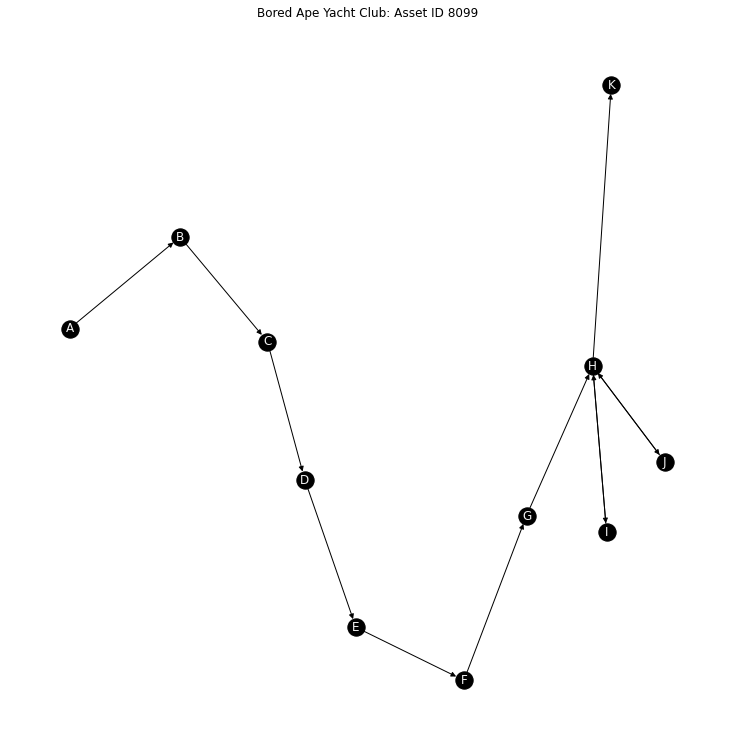

In [18]:
DG_2_b = nx.from_pandas_edgelist(
    df=to_from_node_label_df,
    source='from_node_label',
    target='to_node_label',
    edge_attr=True,
    create_using=nx.DiGraph()
)

pos = nx.spring_layout(DG_2_b)
nx.draw(DG_2_b, pos=pos, node_color='black')
nx.draw_networkx_labels(G=DG_2_b, pos=pos, font_color='whitesmoke')
plt.title('Bored Ape Yacht Club: Asset ID 8099')
plt.show()

### Highlighting Edge Directions
Since we are specifically looking for "wash trading," the direction of transactions and loops between nodes is very important. Though the above graph shows two arrows for such instances (e.g. `H`<->`I`), we can make a much clearer data story by emphasizing the edges using the argument `connectionstyle='arc3, rad = 0.05'`.

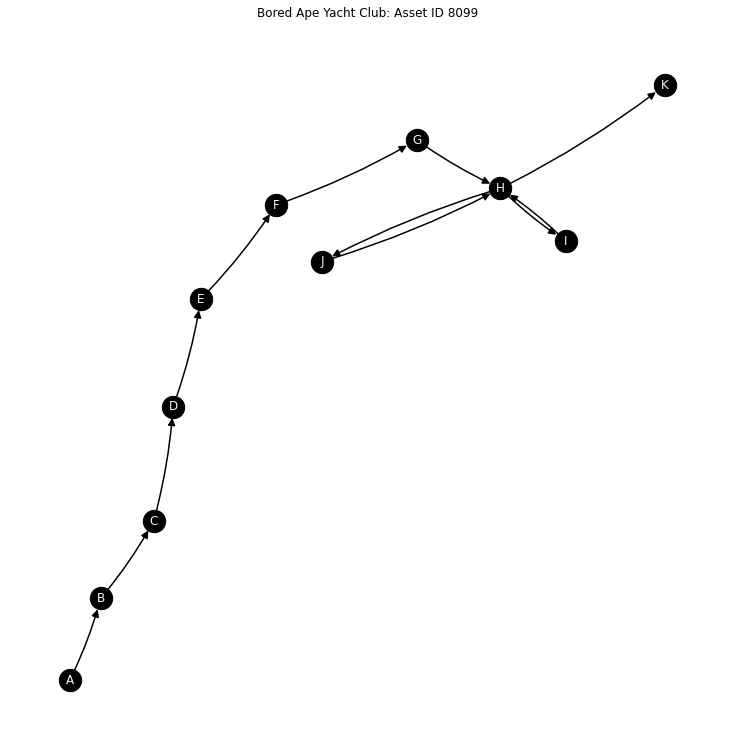

In [19]:
DG_3 = nx.from_pandas_edgelist(
    df=to_from_node_label_df,
    source='from_node_label',
    target='to_node_label',
    edge_attr=True,
    create_using=nx.DiGraph()
)

pos = nx.spring_layout(DG_3)
nx.draw(
    G=DG_3,
    pos=pos,
    arrowsize=15,
    connectionstyle='arc3, rad = 0.05',
    node_color='black',
    with_labels=True,
    node_size=500,
    width=1.5
    )
nx.draw_networkx_labels(G=DG_3, pos=pos, font_color='whitesmoke')
plt.title('Bored Ape Yacht Club: Asset ID 8099')
plt.show()

### Adding Edge Labels
The updated edges make it much more clear as to the direction of transactions in conjunction with the sequential node labels. But how do we determine when a transaction is just a transfer or a sale? There are multiple ways in which we can represent this, but I believe the easiest way is to simply show the dollar amount between each transaction, where $0.00 represents a transfer.

Notes:
- Transferring between multiple wallets is a common practice and is expected-- specifically transferring from a "hot wallet" to a "cold wallet" to keep one's assets more secure and less likely to be hacked.
- Be mindful of your audience on how you represent amounts, as beginner audiences prefer $USD while more crypto advanced audiences would prefer the amount in the respective crypto (e.g. ETH).

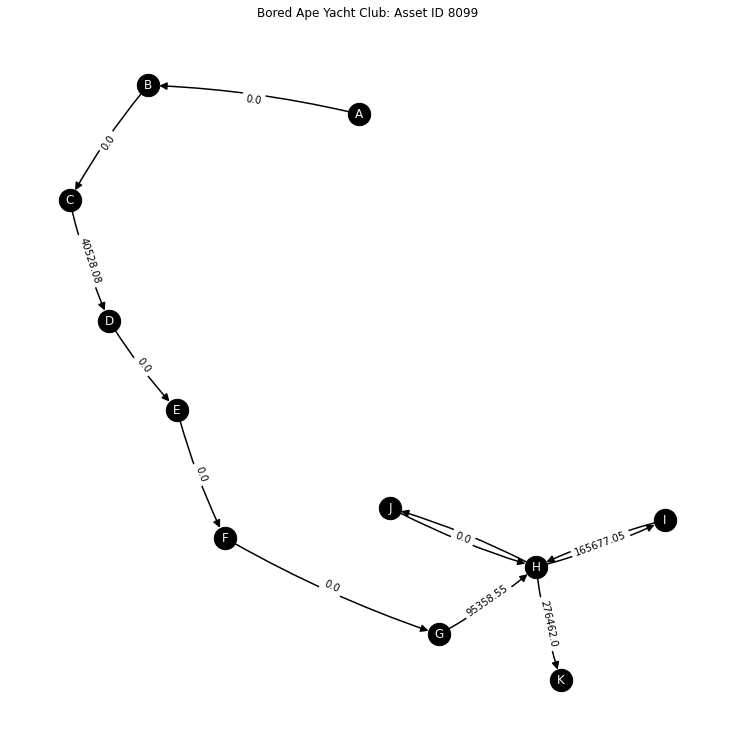

In [20]:
DG_4 = nx.from_pandas_edgelist(
    df=to_from_node_label_df,
    source='from_node_label',
    target='to_node_label',
    edge_attr=True,
    create_using=nx.DiGraph()
)

pos = nx.spring_layout(DG_4)
nx.draw(
    G=DG_4,
    pos=pos,
    arrowsize=15,
    connectionstyle='arc3, rad = 0.05',
    node_color='black',
    with_labels=True,
    node_size=500,
    width=1.5
    )
nx.draw_networkx_labels(G=DG_4, pos=pos, font_color='whitesmoke')
nx.draw_networkx_edge_labels(
    DG_4,
    pos=pos,
    edge_labels=nx.get_edge_attributes(DG_4,'sale_price_usd')
    )
plt.title('Bored Ape Yacht Club: Asset ID 8099')
plt.show()

### Organizing the Network Graph's Layout
You might have noticed that each time we run `nx.draw()` the nodes and edges are in different layouts at random. The NetowrkX package gives us numerous layout options to best fit how we frame the data problem (https://networkx.org/documentation/stable/reference/drawing.html). I highly suggest playing around with the different layouts to determine the data story you want to tell. For me, I personally like the `planar_layout()` as it 1) creates consistent network graph positions, and 2) ensures that nodes and edges do not overlap.

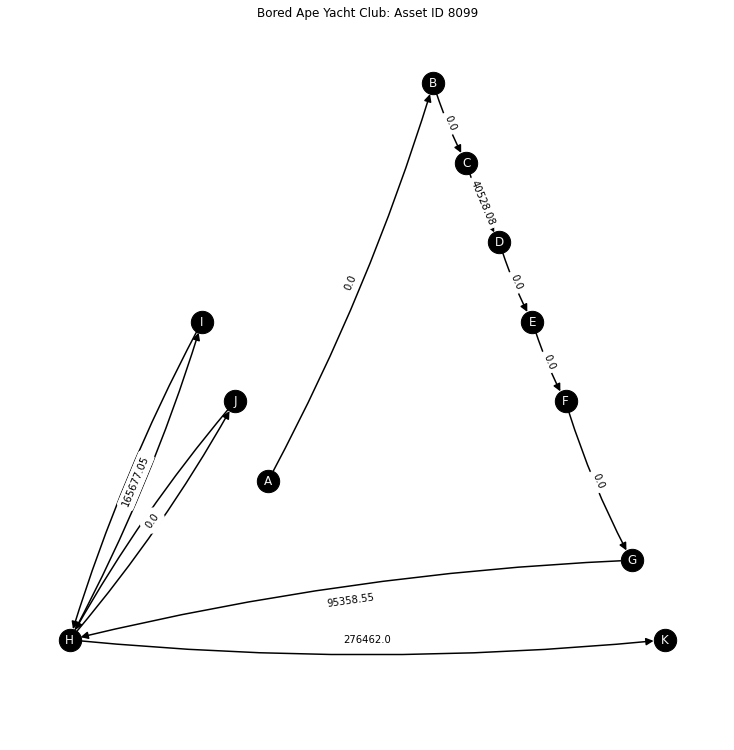

In [21]:
DG_5 = nx.from_pandas_edgelist(
    df=to_from_node_label_df,
    source='from_node_label',
    target='to_node_label',
    edge_attr=True,
    create_using=nx.DiGraph()
)

pos = nx.planar_layout(DG_5)
nx.draw(
    G=DG_5,
    pos=pos,
    arrowsize=15,
    connectionstyle='arc3, rad = 0.05',
    node_color='black',
    with_labels=True,
    node_size=500,
    width=1.5
    )
nx.draw_networkx_labels(G=DG_5, pos=pos, font_color='whitesmoke')
nx.draw_networkx_edge_labels(
    DG_5,
    pos=pos,
    edge_labels=nx.get_edge_attributes(DG_5,'sale_price_usd')
    )
plt.title('Bored Ape Yacht Club: Asset ID 8099')
plt.show()

### Did BAYC 8099 NFT Experience Wash Trading?
Specifically look at node `H` where this wallet first increases the price from $95k to $166k between `H`<->`I`, then adds more transactions via transfers between `H`<->`J`. Finally, node `H` sells the potentially artificially increased NFT to node `K`.

Though this graph can't definitively state that node `H` engaged in wash trading, as we don't know if nodes `H, I, J` are wallets owned by the same person, seeing loops for a node where the price increases should flag the need to do more due diligence. For example, one could look at etherscan.com to review the transactions between wallets `0xe4bc96b24e0bdf87b4b92ed39c1aef8839b090dd`, `0x7e99611cf208cb097497a59b3fb7cb4dfd115ea9`, and `0xcbc9f463f83699d20dd5b54be5262be69a0aea9f` (nodes `H, I, J` respectively). Maybe node `H` had sellers remorse and wanted their NFT back-- it's not uncommon for investors to get attached to their beloved NFTs. But if I saw numerous transactions between the wallets associated with nodes `H, I, J`, it would raise further red flags for the NFT asset.

## Putting It All Together

In [22]:
import logging
from operator import itemgetter
from string import ascii_uppercase

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd


class NftToNetworkGraph:
    """This class contains a set of functions to take the data derived from the
    NFT Analyst Starter Pack from a16z
    (https://github.com/a16z/nft-analyst-starter-pack), and generate both
    network graphs and metadata reports for the transactions of a respective
    NFT asset.
    """

    def __init__(self, nft_transactions_data: pd.DataFrame) -> None:
        """Initialize the class with the dataframe derived from the a16z NFT
        Analyst Starter Pack. Data must include the columns "from_address" and
        "to_address" as they will serve as the graph nodes.

        Arguments:
        nft_transactions_data -- dataframe containing NFT transaction data.
        """
        self.nft_transactions_data = nft_transactions_data

    def _filter_to_specific_nft(
        self, nft_data: pd.DataFrame, asset_id: str
    ) -> pd.DataFrame:
        """Function filters NFT data to only transaction logs related to the
        specified asset ID. This is important to minimize the possibility of
        creating a graph with too many nodes and edges to display.

        Arguments:
        nft_data -- dataframe containing NFT transaction data.
        asset_id -- string representing the ID of a respective NFT.
        """
        df = nft_data.copy()

        filtered_nft_data = df.loc[df["asset_id"] == asset_id]

        filtered_nft_data_len = len(filtered_nft_data)
        if filtered_nft_data_len == 0:
            asset_contract = df["asset_contract"][0]
            etherscan_link = f"https://etherscan.io/token/{asset_contract}?a={asset_id}"
            raise Exception(
                f"No transactions found for asset {asset_id}. Investigate"
                f"further on Etherscan: {etherscan_link}"
            )

        logging.info(
            "Filtered to asset ID %s with %s transactions.",
            asset_id,
            filtered_nft_data_len,
        )

        return filtered_nft_data

    # this function is a great candidate for refactoring later
    def _get_ordered_node_labels(self, nft_data: pd.DataFrame) -> pd.DataFrame:
        """Function transforms the wallet address hashes into uppercase letters.
        Labels are ordered sequentially in accordance to when the wallet
        address first appeared for transactions for a specific NFT asset.

        Arguments:
        nft_data -- dataframe containing NFT transaction data.
        """
        df = nft_data.copy()

        logging.info("Determining unique wallet addresses and their order.")

        unique_ordered_from_addresses = df.loc[:, ["from_address", "date"]].rename(
            columns={"from_address": "address"}
        )

        unique_ordered_to_addresses = df.loc[:, ["to_address", "date"]].rename(
            columns={"to_address": "address"}
        )

        unique_ordered_all_addresses = (
            pd.concat([unique_ordered_from_addresses, unique_ordered_to_addresses])
            .groupby("address")
            .agg("min")
            .sort_values("date", ascending=True)
            .reset_index()
        )

        # https://stackoverflow.com/questions/50860366/pandas-set-row-values-to-letter-of-the-alphabet-corresponding-to-index-number
        # get upper case letter in order of index
        logging.info("Assigning sequential letters to wallet addresses.")
        node_label_series = pd.Series(
            itemgetter(*unique_ordered_all_addresses.index)(ascii_uppercase),
            name="node_label",
        )
        address_labels_df = pd.concat(
            [unique_ordered_all_addresses, node_label_series], axis=1
        ).loc[:, ["address", "node_label"]]

        from_node_label_df = df.merge(
            address_labels_df, how="left", left_on="from_address", right_on="address"
        ).rename(columns={"node_label": "from_node_label"})

        to_from_node_label_df = from_node_label_df.merge(
            address_labels_df, how="left", left_on="to_address", right_on="address"
        ).rename(columns={"node_label": "to_node_label"})

        # drop duplicate merge columns
        to_from_node_label_df.drop(
            columns=["address_x", "address_y"], axis=1, inplace=True
        )

        logging.info("Node labels successfully generated.")

        return to_from_node_label_df

    def prepare_nft_data(self, asset_id: str) -> pd.DataFrame:
        """Function provides the necessary transformations for the provided NFT
        data to 1) filter to the desired asset ID, and 2) prepare the metadata
        for network graphs.

        Arguments:
        asset_id -- string representing the ID of a respective NFT.
        """
        logging.info("Preparing NFT data for network graph.")

        nft_df = self.nft_transactions_data.copy()
        filtered_df = self._filter_to_specific_nft(nft_df, asset_id)
        label_df = self._get_ordered_node_labels(filtered_df)

        logging.info("NFT data preparation complete.")

        return label_df

    def generate_network(
        self, prepared_nft_data: pd.DataFrame
    ) -> nx.classes.digraph.DiGraph:
        """Function generates a directional graph representing transactions for
        the selected NFT asset.

        Arguments:
        prepared_nft_data -- NFT transaction data that has been filtered and
            transformed to best fit a network graph.
        """
        logging.info("Generating network graph.")

        asset_dg = nx.from_pandas_edgelist(
            df=prepared_nft_data,
            source="from_node_label",
            target="to_node_label",
            edge_attr=True,
            create_using=nx.DiGraph(),
        )

        logging.info("Network graph successfully created.")

        return asset_dg

    def print_asset_meta_data_report(self, asset_id: str) -> None:
        """Function prints organized metadata of an NFT asset, summary stats,
        the node label to wallet address mapping, and useful links to further
        explore the asset via OpenSea and Etherscan.

        Arguments:
        asset_id -- string representing the ID of a respective NFT.
        """

        logging.info("Preparing metadata report for NFT asset ID %s.", asset_id)

        prepared_nft_data = self.prepare_nft_data(asset_id)
        asset_contract = prepared_nft_data["asset_contract"][0]
        sell_nft_data = prepared_nft_data[
            prepared_nft_data["transaction_type"] == "sell"
        ]
        transfer_nft_data = prepared_nft_data[
            prepared_nft_data["transaction_type"] == "transfer"
        ]

        from_addresses_data = prepared_nft_data.loc[
            :, ["from_address", "from_node_label"]
        ].rename(columns={"from_address": "address", "from_node_label": "node_label"})

        to_addresses_data = prepared_nft_data.loc[
            :, ["to_address", "to_node_label"]
        ].rename(columns={"to_address": "address", "to_node_label": "node_label"})

        adresses_data = (
            pd.concat([from_addresses_data, to_addresses_data])
            .drop_duplicates()
            .sort_values(by=["node_label"], ascending=True)
            .rename({"from_address": "adress", "from_node_label": "node_label"})
            .reset_index(drop=True)
        )

        report_text = f"""
        +-----------------------+
        | BAYC NFT Asset Report |
        +-----------------------+
        Contract Address: {asset_contract}
        Asset ID: {asset_id}
        OpenSea: https://opensea.io/assets/ethereum/{asset_contract}/{asset_id}
        Etherscan: https://etherscan.io/token/{asset_contract}?a={asset_id}
        Mint Date: {min(prepared_nft_data['date'])}
        Latest Recorded Transaction Date: {max(prepared_nft_data['date'])}
        Times Sold: {len(sell_nft_data)}
        Times Transferred: {len(transfer_nft_data)}
        Min Sell Price: ${int(min(sell_nft_data['sale_price_usd'], default=0))}
        Max Sell Price: ${int(max(sell_nft_data['sale_price_usd'], default=0))}
        Unique Wallet Holder Count: {len(adresses_data)}
        Wallet Address to Node Label Key:
        {adresses_data}
        """

        print(report_text)

    def generate_graph_plot_from_asset_id(self, asset_id: str) -> None:
        """Function generates a network graph visualization of the desired NFT
        asset ID, with emphasis on highlighting transaction directions and
        price in $USD.

        Arguments:
        asset_id -- string representing the ID of a respective NFT.
        """

        logging.info("Preparing network graph plot for asset ID %s.", asset_id)

        prepared_nft_data = self.prepare_nft_data(asset_id)
        asset_dg = self.generate_network(prepared_nft_data)

        # planar_layout positionsq nodes without edge intersections
        pos = nx.planar_layout(asset_dg)
        nx.draw(
            G=asset_dg,
            pos=pos,
            arrowsize=15,
            connectionstyle="arc3, rad = 0.05",
            node_color="black",
            with_labels=True,
            node_size=500,
            width=1.5,
        )
        nx.draw_networkx_labels(G=asset_dg, pos=pos, font_color="whitesmoke")
        nx.draw_networkx_edge_labels(
            asset_dg,
            pos=pos,
            edge_labels=nx.get_edge_attributes(asset_dg, "sale_price_usd"),
        )
        plt.title(f"Bored Ape Yacht Club: Asset ID {asset_id}")
        plt.show()

    def generate_asset_report(self, asset_id: str) -> None:
        """Function prints a summary stats and metadata report, as well as a
        network graph visualization of the transactions for the provided NFT
        asset ID.

        Arguments:
        asset_id -- string representing the ID of a respective NFT.
        """
        self.print_asset_meta_data_report(asset_id)
        self.generate_graph_plot_from_asset_id(asset_id)


        +-----------------------+
        | BAYC NFT Asset Report |
        +-----------------------+
        Contract Address: 0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d
        Asset ID: 8099
        OpenSea: https://opensea.io/assets/ethereum/0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d/8099
        Etherscan: https://etherscan.io/token/0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d?a=8099
        Mint Date: 2021-05-01
        Latest Recorded Transaction Date: 2021-11-04
        Times Sold: 5
        Times Transferred: 7
        Min Sell Price: $40528
        Max Sell Price: $276462
        Unique Wallet Holder Count: 11
        Wallet Address to Node Label Key:
                                               address node_label
0   0x0000000000000000000000000000000000000000          A
1   0x442dccee68425828c106a3662014b4f131e3bd9b          B
2   0x8ad272ac86c6c88683d9a60eb8ed57e6c304bb0c          C
3   0x7d88aa989068e65190031a13c809e27fcb3aca52          D
4   0xfa68378c74d13a9509fefd0a09e

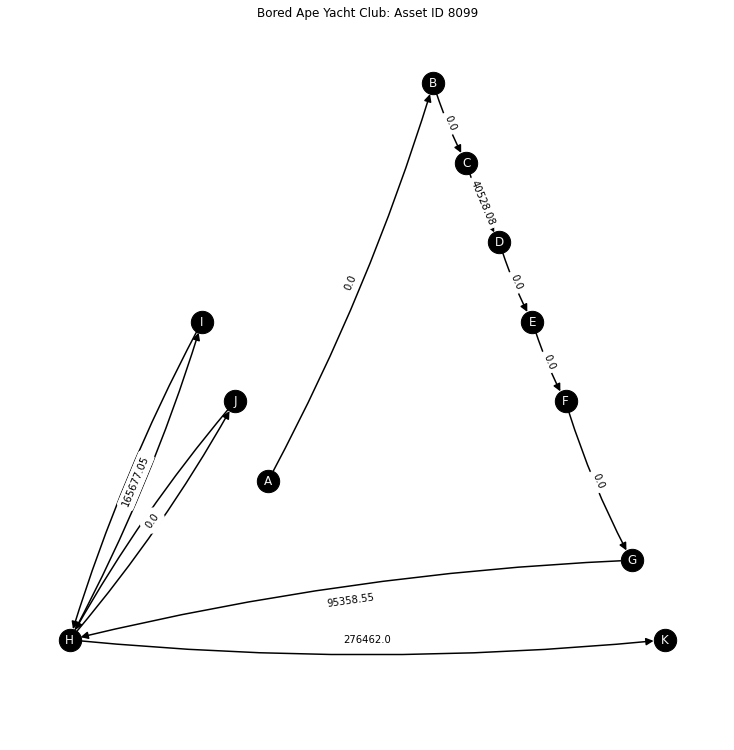

In [23]:
nft_to_graph = NftToNetworkGraph(prepared_bayc_sales_transfers)
nft_to_graph.generate_asset_report('8099')


        +-----------------------+
        | BAYC NFT Asset Report |
        +-----------------------+
        Contract Address: 0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d
        Asset ID: 1000
        OpenSea: https://opensea.io/assets/ethereum/0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d/1000
        Etherscan: https://etherscan.io/token/0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d?a=1000
        Mint Date: 2021-05-01
        Latest Recorded Transaction Date: 2022-01-21
        Times Sold: 1
        Times Transferred: 5
        Min Sell Price: $1875
        Max Sell Price: $1875
        Unique Wallet Holder Count: 5
        Wallet Address to Node Label Key:
                                              address node_label
0  0x0000000000000000000000000000000000000000          A
1  0xef8e27bad0f2eee4e691e5b1eaab3c019e369557          B
2  0x9ad85d7c0f7eff3d0718c3a3a032557558f7048b          C
3  0xcfbecd1ba28af429c4063e33901f8c0bd53ec9f1          D
4  0x8bbc693d042cea740e4ff01d7e0efb36110c3

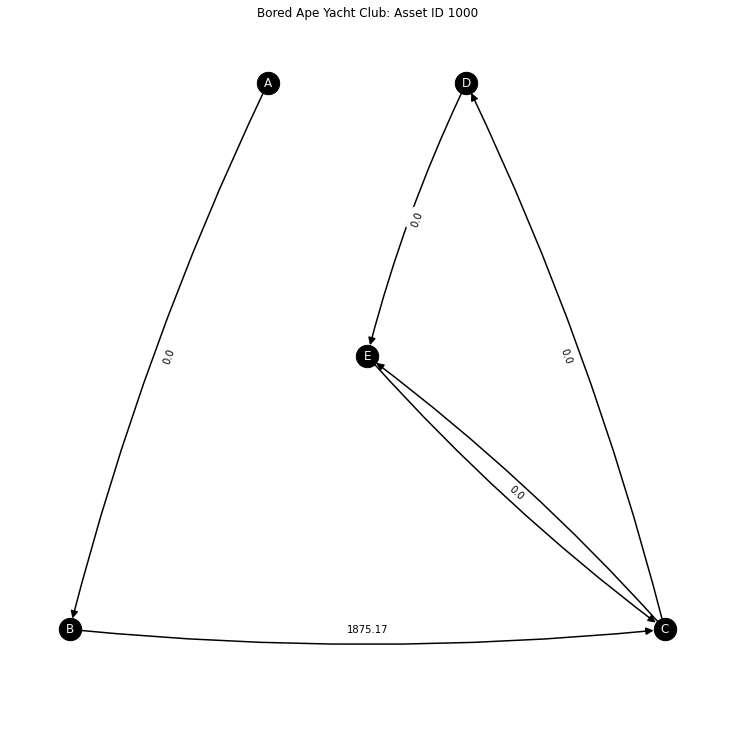


        +-----------------------+
        | BAYC NFT Asset Report |
        +-----------------------+
        Contract Address: 0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d
        Asset ID: 98
        OpenSea: https://opensea.io/assets/ethereum/0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d/98
        Etherscan: https://etherscan.io/token/0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d?a=98
        Mint Date: 2021-04-24
        Latest Recorded Transaction Date: 2022-03-27
        Times Sold: 2
        Times Transferred: 3
        Min Sell Price: $2271
        Max Sell Price: $252786
        Unique Wallet Holder Count: 6
        Wallet Address to Node Label Key:
                                              address node_label
0  0x0000000000000000000000000000000000000000          A
1  0x87773aaccabe6928ff0f764fe2887f41929fa855          B
2  0xc991fd20ffd2ee620a73ea7dadd051fe86d39b15          C
3  0x5d94df1c12a5d796cb889edda6c40f659f39f43f          D
4  0x16205a6048b6af17f1ac1a009bbf2ed9289e6921 

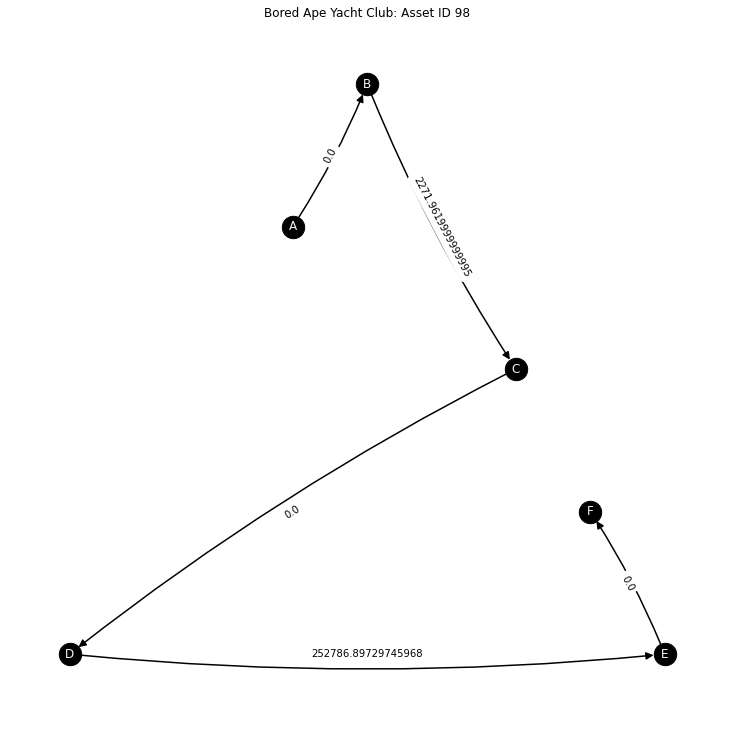


        +-----------------------+
        | BAYC NFT Asset Report |
        +-----------------------+
        Contract Address: 0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d
        Asset ID: 7848
        OpenSea: https://opensea.io/assets/ethereum/0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d/7848
        Etherscan: https://etherscan.io/token/0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d?a=7848
        Mint Date: 2021-05-01
        Latest Recorded Transaction Date: 2021-10-22
        Times Sold: 5
        Times Transferred: 4
        Min Sell Price: $1299
        Max Sell Price: $3524
        Unique Wallet Holder Count: 9
        Wallet Address to Node Label Key:
                                              address node_label
0  0x0000000000000000000000000000000000000000          A
1  0x544fca5eef17d75a273955ba6fd16fe3c6e620aa          B
2  0x4ed4d3263b4b0a75802833a58d1016280953a86f          C
3  0x7a09696e30192974d732ceb3e82e1306385886ff          D
4  0x59edf50f7078442b9a8f2d732bfa91c9bc9cf

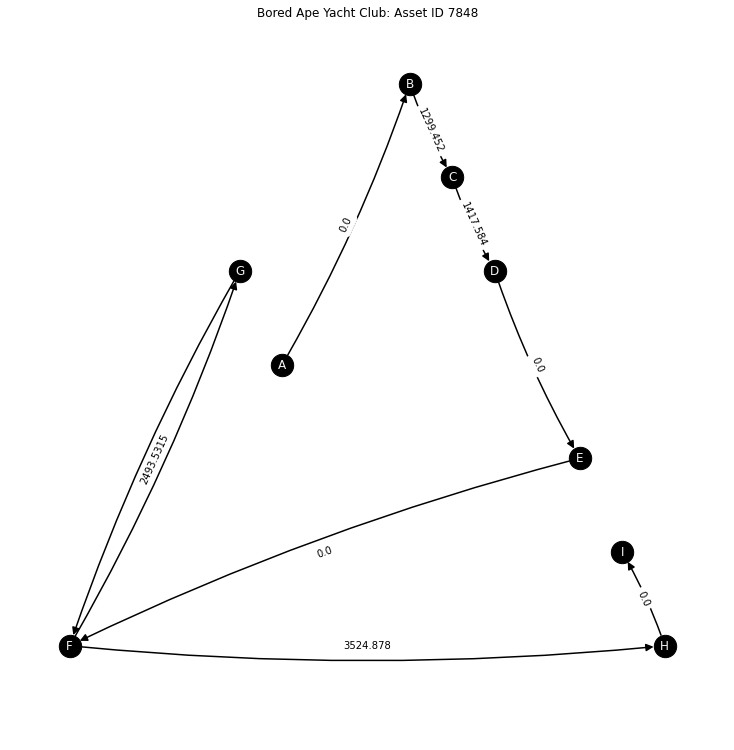


        +-----------------------+
        | BAYC NFT Asset Report |
        +-----------------------+
        Contract Address: 0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d
        Asset ID: 8310
        OpenSea: https://opensea.io/assets/ethereum/0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d/8310
        Etherscan: https://etherscan.io/token/0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d?a=8310
        Mint Date: 2021-05-01
        Latest Recorded Transaction Date: 2022-03-21
        Times Sold: 6
        Times Transferred: 3
        Min Sell Price: $2829
        Max Sell Price: $246727
        Unique Wallet Holder Count: 10
        Wallet Address to Node Label Key:
                                              address node_label
0  0x0000000000000000000000000000000000000000          A
1  0x9d4c1c518442ad9eb23cb79a4792d508b49c81af          B
2  0x49205e7f66591d3742bdf61b5477dd5579896e9a          C
3  0xd472b0798421159999e3db0aaa2d53bc0d7acfa3          D
4  0x975222a8365e6ab51b7867524f77261cd4

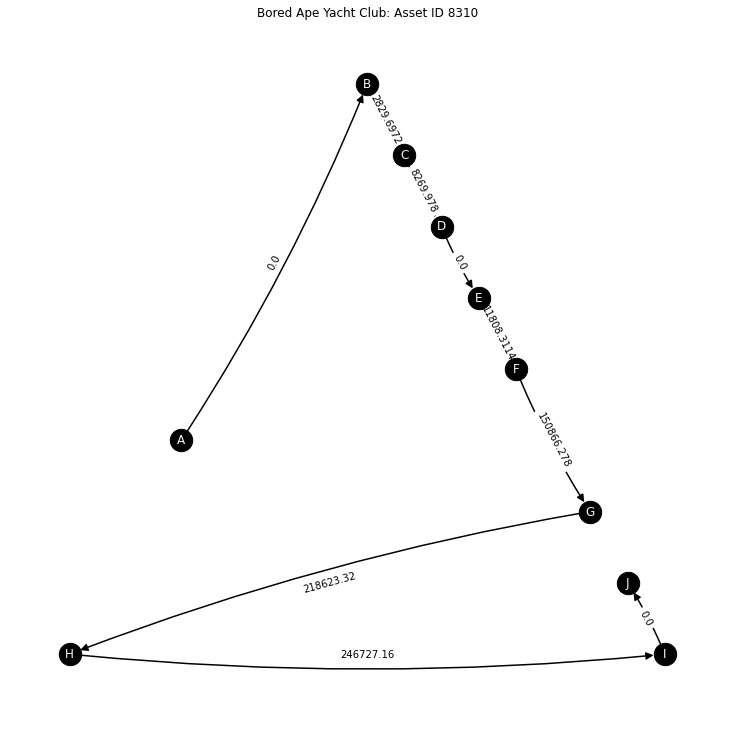

In [24]:
asset_id_list = ['1000', '98', '7848', '8310']
for asset_id in asset_id_list:
    nft_to_graph.generate_asset_report(asset_id)

# End of Notebook